## 1. LinkedIn: A/B Testing Invitation to connect email campaign
A/B tested email subject line:
- A: “Do you know Miguel Fuentes?”
- B: “Do you know Miguel Fuentes fellow ESADE graduate?”

We have chosen **engagement** as a metric (number of clicks per visitors) and will perform an A/B test to discover whether B causes more engagement than their old email marketing campaign A.<br>
<br>
The dataset "website.csv" information recorded on LinkedIn's website of all visitors, assigned to A or B in this experiment. 
<br>
The data contains information about 7 weeks. **Important Note: The experiment started on the first day of Week 3.**

In [29]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# load data
website = pd.read_csv('https://raw.githubusercontent.com/amazirnim/linkedin/main/website.csv',index_col=0)
website.sort_values(by=['id','week']).head(14)
website.shape

,id,clicks,cond,week
22247,121905,27,A,1
63789,121905,27,A,2
105331,121905,36,A,3
146873,121905,24,A,4
188415,121905,24,A,5
229957,121905,27,A,6
271499,121905,19,A,7
5398,121930,8,B,1
46940,121930,7,B,2
88482,121930,8,B,3


(149013, 4)

# 2. Analysis unit ≠ Randomisation unit

We observe a first problem that would bias our statistical analysis. The unit of analysis is different than the unit of randomisation.
- Unit of Randomisation: Each user_Id
- Unit of Analysis: User per week

This is a problem because the user_id that we observe over the weeks are **not independent observations** (i.e. a user that clicks 25 times week 4 is also likely to also clicks around 25 times the other weeks).

However, the statistical software assumes every observation is independant.

**Solution**: Aggregate data to level of randomisation:
We will **analyse users instead of users per week**. To do so, we will combine the number of clicks for each specific user for week 1 and 2 (the baseline) and for week 3 to 7 (where we perform the experiment).

# 2.1. Difference between group A and B in Baseline (Week 1 and 2)
There should be **no difference** between the group A and B in week 1 and 2, since we didn't bring any change yet. 

In [30]:
# Combining clicks for weeks 1 and 2
baseline = website[website['week'] <= 2]
pivoted = baseline.groupby('id').agg({'clicks':'sum'}) 
baseline = baseline.drop(['clicks', 'week'], axis=1).drop_duplicates()
before_treatment = pivoted.merge(baseline, on = 'id', how='left')
before_treatment.head()
before_treatment.shape

,id,clicks,cond
0,121905,54,A
1,121930,15,B
2,121947,38,B
3,122021,9,A
4,122028,3,A


(22244, 3)

In [31]:
a_baseline = before_treatment[before_treatment['cond'] == 'A']
b_baseline = before_treatment[before_treatment['cond'] == 'B']

print()
print('###### BASELINE ######')
print()
print('WEEK 1 AND 2 - GROUP A')
print()
print(a_baseline.clicks.sum(),'clicks')
print(a_baseline.clicks.count(), 'users')
print(round(a_baseline.clicks.mean(), 2)/2, 'average click per user (User Engagement)')

print()
print('WEEK 1 AND 2 - GROUP B')
print()
print(b_baseline.clicks.sum(), 'clicks')
print(b_baseline.clicks.count(), 'users')
print(round(b_baseline.clicks.mean(), 2)/2, 'average click per user (User Engagement)')


###### BASELINE ######

WEEK 1 AND 2 - GROUP A

422221 clicks
11171 users
18.9 average click per user (User Engagement)

WEEK 1 AND 2 - GROUP B

420527 clicks
11073 users
18.99 average click per user (User Engagement)


**We observe no difference between the two groups as expected. It looks like the number of users, number of clicks and the user engagement is similar between the two groups.**

# 2.2. Difference between group A and B in Treatment (Week 3 to 7)

Reminder:
- A: “Do you know Miguel Fuentes?” (Control Group)
- B: “Do you know Miguel Fuentes fellow ESADE graduate?” (Treatment Group)

In [32]:
# Combining clicks for weeks 3 to 2
treatment = website[website['week'] > 2]
pivoted = treatment.groupby('id').agg({'clicks':'sum'})
treatment = treatment.drop(['clicks', 'week'], axis=1).drop_duplicates()
after_treatment = pivoted.merge(treatment, on = 'id', how='left')
after_treatment.head()
after_treatment.shape

,id,clicks,cond
0,121905,130,A
1,121930,49,B
2,121947,90,B
3,121971,4,B
4,122021,25,A


(25670, 3)

In [33]:
a_treatment = after_treatment[after_treatment['cond'] == 'A']
b_treatment = after_treatment[after_treatment['cond'] == 'B']

print()
print('###### AFTER TREATMENT ######')
print()
print('WEEK 3 to 7 - GROUP A (Control)')
print()
print(a_treatment.clicks.sum(),'clicks')
print(a_treatment.clicks.count(), 'users')
print(round(a_treatment.clicks.mean(), 2)/5, 'average click per user (User Engagement)')

print()
print('WEEK 3 to 7 - GROUP B (Treatment)')
print()
print(b_treatment.clicks.sum(), 'clicks')
print(b_treatment.clicks.count(), 'users')
print(round(b_treatment.clicks.mean(), 2)/5, 'average click per user (User Engagement)')


###### AFTER TREATMENT ######

WEEK 3 to 7 - GROUP A (Control)

1051611 clicks
12197 users
17.244 average click per user (User Engagement)

WEEK 3 to 7 - GROUP B (Treatment)

1101263 clicks
13473 users
16.348 average click per user (User Engagement)


# 2.3. Let's see if there is statistical significance between the Engagement of Group A and Group B

cond,A,B
clicks,17.283683,16.361002
clicks,17.290800,16.314389
clicks,17.342320,16.420605
clicks,17.285958,16.636468
clicks,17.351678,16.390177
...,...,...
clicks,17.213305,16.356640
clicks,17.061541,16.200104
clicks,17.439319,16.544915
clicks,17.162876,16.401921


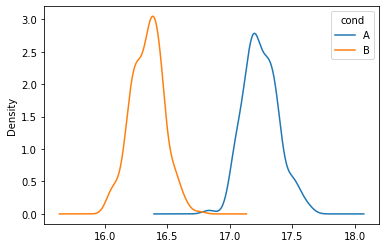

In [34]:
confidence = []
# Iterate 300 times this experiment.
for i in range(300):
    mean_clicks = after_treatment.sample(frac=1, replace = True).groupby('cond')['clicks'].mean()/5
    confidence.append(mean_clicks)
    
# Transforming the list to a DataFrame
confidence = pd.DataFrame(confidence) 
confidence

# A Kernel Density Estimate plot of the bootstrap distributions
confidence.plot.kde()

Text(0.5, 0, 'difference')

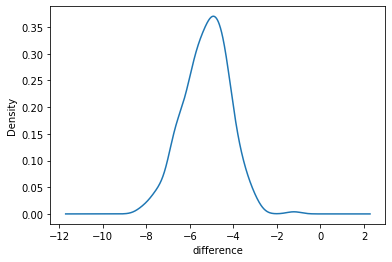

In [35]:
# Adding a column with the % difference between the two A and B groups
confidence['diff'] = (confidence['B'] - confidence['A'])/confidence['A']*100

# Ploting the bootstrap % difference
ax = confidence['diff'].plot.kde()
ax.set_xlabel("difference")

In [36]:
# Calculating the probability that the group a and b are different during the baseline week.
prob = (confidence['diff'] < 0.0).sum()/(confidence['diff'] < 0).count()

# Pretty printing the probability
print(prob)

1.0


**So we are confident to say that A: “Do you know Miguel Fuentes?”(Control) is significantly better than B: “Do you know Miguel Fuentes fellow ESADE graduate?” (Treatment)?**
<br>
<br>
<br>
<br>
<br>
...
<br>
<br>
<br>
<br>
<br>

**No. Actually, if we have a closer look at the data, we observe that our key metric of User Engagement (number of clicks per user) have indeed decreased with the Treatment B. However, the number of unique users and total number of clicks has actually increased with Treatment B (from 12197 users to 13473 users). Why is that?** 

# 3. Introducing the Self-selection Bias

We should be careful with the **SELF-SELECTION BIAS**. Emails are usually sent to members independent of whether they visit the online site or not. Here we are introducing a bias, because if the treatment email (B: “Do you know Miguel Fuentes fellow ESADE graduate?”) has a more attractive subject line, it will encourage more members to click and visit the website. As a result, we will see a drop in key performance metrics such as the number of clicks per users because the email of Group B attracts more less engaged members to visit LinkedIn.


We discovered that the Group B (Treatment) actually brought more unique users on-board. And those users are not users that engage a lot with the product:
- **High engagement users** are likely to click in both links and visit many pages afterwards.
- **Low engagement users** are more likely to click in the B option but visit fewer pages afterwards. They will lower the engagement metric in the B group. Therefore, we will observe a decrease in the number of clicks per user! Contrarily, low engagement users will ignore the mail A, increasing the proportion of high engagement users in the sample A.



To solve this issue there are three solutions:
1. Experiment with **Random Assignment** (not allowing users to self-select by clicking on the email link). However, we cannot apply this method since in a email campaign, users have the ability to choose whether to click or not.
2. We can use an **Intention-to-Treat** method were we do not measure the engagement of those who clicked on the link but we could look at everyone that has received the email (whether they clicked on the email or not).
3. We can use a **Within-person before-after** method where we observe if a specific user "X" has an increase in engagement in the baseline weeks (week 1 and 2) vs the treatment weeks (week 3 to 7). 

# 4. Conclusion

- A/B testing is a way to evaluate the impact of any change on user engagement and is a very useful tool to make data-driven decisions. 
- However, controlled experiments also face challenges and pitfalls that we should be aware of to avoid making biased decisions. 